In [17]:
import glob
import os
import random
import threading

import barcode
import cv2
import numpy as np
import skimage
from barcode import EAN13
from barcode.writer import ImageWriter
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFilter, ImageFont, ImageOps

from nutritionLabelGenerator import NutritionLabelGenerator
from util import cvt_to_perspective
from perturbed_mesh import perturbed_mesh

In [18]:
w, h = random.randrange(400, 600), random.randrange(600, 1000)
print('width:', w, 'height:', h)

width: 557 height: 677


In [19]:
def draw_light_bubble():
    """return Light Bubbles
    """
    noise = np.random.default_rng().integers(0, 255, (h, w), np.uint8, True)
    blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)
    stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)
    thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.merge([mask,mask,mask])
    return mask

def draw_random_shape(img):
    """Add random shape to bg
    """
    mask = draw_light_bubble()
    img = np.array(img)
    img = cv2.add(img, mask)
    img = np.where(mask==(255,255,255), 
                (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), 
                img).astype(np.uint8)
    return img

In [20]:
DUMMY_TEXT = """
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Proin vitae augue ut lectus tempus volutpat sed nec tortor. Nam feugiat magna eu dui eleifend luctus. Vestibulum condimentum ipsum id augue varius, nec interdum nunc pharetra. Aenean rutrum rhoncus dolor eget mattis. Maecenas ac magna vel nulla condimentum consequat at at nisl. Vestibulum eleifend auctor magna. Nullam aliquam ornare augue. Sed quis eros pharetra, molestie quam a, rutrum purus. Vivamus sagittis metus elementum, finibus dolor nec, iaculis nunc. Nulla id libero id risus iaculis ullamcorper vitae vel nisl. Aliquam cursus metus tortor, tristique finibus dui suscipit et. Donec vehicula, purus non ultrices varius, nisl massa pharetra nulla, et scelerisque erat ligula nec enim. In dolor ipsum, vulputate convallis mi non, rutrum porta nibh.
Nunc euismod enim vitae enim consectetur porttitor. Nullam ex dolor, malesuada quis lectus sed, ultrices finibus sapien. Quisque ut mattis felis. Fusce euismod posuere dolor ac imperdiet. Nulla malesuada sed lorem ut dignissim. Praesent sed felis et odio euismod bibendum. In sed tempus quam, eget pharetra ex. Aenean nibh est, interdum ut blandit ac, consectetur in neque. Vestibulum hendrerit tortor dictum, auctor libero quis, tincidunt enim. Aenean enim neque, semper a ullamcorper in, aliquam non urna. In ut nibh libero. In metus felis, porta et dignissim nec, faucibus rutrum libero. Nam risus quam, viverra nec pellentesque quis, convallis vel tellus. Vestibulum a nulla feugiat, molestie massa in, feugiat odio. Donec gravida nisl eget leo dignissim, sed vulputate metus ultricies.
Ut nec nisi id purus porttitor rhoncus. Morbi tempus egestas lacus, quis porta arcu dignissim vel. Sed malesuada faucibus eros cursus mollis. Quisque velit dolor, lobortis bibendum ipsum et, porttitor vestibulum purus. Sed efficitur sodales aliquam. Ut vestibulum molestie dolor, ut ornare ante bibendum eget. Nullam in enim leo. Fusce non nisl eu purus maximus sodales non ut diam. Nullam euismod sit amet lectus feugiat varius. Integer faucibus, ante nec ullamcorper semper, neque est sollicitudin arcu, vitae pharetra nisi est vitae ex.
Mauris vel nisl ut urna tristique semper. Aliquam pharetra felis metus, ac porttitor sem interdum nec. Curabitur orci diam, pellentesque non libero cursus, porta venenatis arcu. Aliquam sit amet tincidunt arcu, sit amet vestibulum magna. Etiam luctus ligula ut varius placerat. Aliquam erat volutpat. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Nullam pharetra, ante id consequat varius, metus metus suscipit felis, eu varius ipsum ligula vitae mi. Phasellus auctor nibh et leo maximus, ac ullamcorper nibh rhoncus. Integer ullamcorper massa vel orci cursus posuere. In vitae velit at sem finibus tincidunt. Ut euismod ipsum eu metus vestibulum semper. Donec efficitur tellus in elit malesuada commodo. Pellentesque auctor tempus dictum.
Cras blandit vehicula enim, non accumsan orci malesuada a. Ut dignissim nunc ut ornare varius. Nulla eu erat sem. Integer vitae sodales erat. Morbi ut ex rutrum, ultrices quam non, varius nisl. Aliquam erat volutpat. Nulla varius, sapien quis varius luctus, neque eros commodo dolor, quis mattis risus lectus id diam. Vivamus vitae lectus sem.
""".replace("\n", "").split(" ")
random.shuffle(DUMMY_TEXT)

In [21]:
white = 200
text_color = (random.randint(0, 100), random.randint(0, 100), random.randint(0, 100)) \
        if random.random() < 0.5 else \
            (random.randint(white, 255), random.randint(white, 255), random.randint(white, 255))

In [22]:
def font_name():
    fonts = os.listdir("fonts")
    return "fonts/" + random.choice(fonts)

def draw_dummy_text(img, y: int):
    draw = ImageDraw.Draw(img, "RGB")
    
    x_margin = random.randint(0,20)
    line_width = x_margin
    font = ImageFont.truetype(
                font=font_name(), size=random.randint(20, 25))
            
    text_y = y + 5
    for text in DUMMY_TEXT:
        minx, miny, maxx, maxy = draw.textbbox((0, 0), text + " ", font)
        text_width, text_height = maxx, maxy
        # if text_y exceeds the height of the image, break
        if text_y + text_height >= h:
            text_y += text_height 
            break
        # if the height exceeds the third of the image height, break
        if text_y - y >= h/3: 
            text_y += y + text_height
            break
        if line_width + text_width > (w - x_margin):
            text_y += text_height
            draw.text((x_margin, text_y), text, text_color, font=font)    
            line_width = text_width
        else:
            draw.text((line_width, text_y), text, text_color, font=font)    
            line_width += text_width
    
    return img, text_y

def add_product_name(img, y: int):
    #randomly pick a word from the list in file "product_names.txt"
    product_name = random.choice(open("product_names.txt").read().splitlines())
    #randomly pick a font
    font = ImageFont.truetype(font_name(), size=random.randint(20, 30))
    #draw the product name on the image
    draw = ImageDraw.Draw(img)
    draw.text((random.randint(0, w//2), y), product_name, font=font, fill=text_color)
    #return the bottom y position of the product name
    minx, miny, maxx, maxy = font.getbbox(product_name)
    return img, y + (maxy-miny)

def add_ingredients(img, y: int):
    #randomly pick a word from the list in file "ingredients.txt"
    ingredients = "Ingredients: " + random.choice(open("ingredients.txt").read().splitlines())
    #randomly pick a font
    font = ImageFont.truetype(font_name(), size=random.randint(20, 25))
    draw = ImageDraw.Draw(img)
    #draw the ingredients on the image, automatically wrap the text
    x_margin = random.randint(0,20)
    text_y = y + 5
    line_width = x_margin
    for text in ingredients.split(' '):
        minx, miny, maxx, maxy = draw.textbbox((0, 0), text + ", ", font)
        text_width, text_height = maxx - minx, maxy - miny
        # if text_y exceeds the height of the image, break
        if text_y + text_height >= h: 
            text_y += text_height
            break
        # if the height exceeds the third of the image height, break
        if text_y - y >= h/3: 
            text_y += text_height
            break
        if line_width + text_width > (w - x_margin):
            text_y += text_height
            draw.text((x_margin, text_y), text + ", ", text_color, font=font)    
            line_width = text_width
        else:
            draw.text((line_width, text_y), text + ", ", text_color, font=font)    
            line_width += text_width
    #return the bottom y position of the ingredients
    return img, text_y

def add_barcode(img, y: int):
    #render random EAN13 bar code
    bar_code = barcode.get_barcode_class('ean13')
    bar_code = bar_code(str(random.randint(100000000000, 999999999999)), writer=ImageWriter())
    bar_code = bar_code.render()
    #randomly resize bar code
    bar_code = bar_code.resize(
        (random.randint(w//2, w), 
        random.randint(h//10, h//5))
        )
    #convert self.img to numpy array
    img = np.array(img)
    #paste the bar code to the self.img at random x and given y
    random_x = random.randint(0, w - bar_code.size[0])
    #remove white background of bar code
    bar_code = np.array(bar_code)
    barcode_width, barcode_height = bar_code.shape[1], bar_code.shape[0]
    bar_code = np.where(
        bar_code[:min(barcode_height, img.shape[0]-y)] == 255, 
        img[y:min(y+barcode_height, img.shape[0]), random_x:random_x+barcode_width, :], 
        bar_code[:min(barcode_height, img.shape[0]-y), ...])
    img[y:min(y+barcode_height, img.shape[0]), random_x:random_x+barcode_width] = bar_code
    #convert back to PIL image
    img = Image.fromarray(img)
    #return the bottom y position of the bar code
    return img, y + barcode_height

def add_light_bubble(img):
    mask = draw_light_bubble()
    img = Image.fromarray(cv2.add(np.array(img), mask))
    return np.array(img)

def extract_dominant_color(img):
    img = np.array(img).astype(np.float32)
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, _, centers = cv2.kmeans(img, 1, None, criteria, 10, flags)
    return centers[0][::-1].astype(np.uint8)

In [23]:
def draw_random_element(img):
    orginal_img = img.copy()

    text_color_copy = text_color
    dominate = extract_dominant_color(orginal_img)
    text_color_copy = (255 - dominate[0], 255 - dominate[1], 255 - dominate[2])

    elements = np.random.choice(np.arange(0, 5), replace=False, size=(5))
    y = 0
    #0: Description, 1: Product Name, 2: Nutrition Facts, 3: Ingredients, 4: Barcode
    for element in elements:
        # if y exceeds the height of the image, break
        if y >= h:
            break
        if element == 0:
            #Draw Dummy Text Outside of Table
            img, y = draw_dummy_text(img, y)
        elif element == 1:
            img, y = add_product_name(img, y)
        elif element == 2:
            #Draw Nutrition Table on Given ImageDraw
            draw = ImageDraw.Draw(img, "RGB")
            left_offset = random.randint(0, 30)
            right_offset = random.randint(0, 30)
            bboxes = NutritionLabelGenerator.draw_nutrition_rows(draw, \
                w-left_offset-right_offset, left_offset,\
                y, text_color_copy)
            bboxes = np.array(bboxes)
            # set y equal to the bottom of the table (i.e. the max y value among all boxes)
            y = bboxes[..., 1].max()
            # if the y values in bboxes are greater than the height of the image, 
            # shrink them to the height of the image
            bboxes[..., 1] = np.where(bboxes[..., 1] >= h, h - 1, bboxes[..., 1])
        elif element == 3:
            img, y = add_ingredients(img, y)
        elif element == 4:
            print("y:", y)
            img, y = add_barcode(img, y)
    return img, bboxes

In [24]:
def perspectiveWrap(img):
    input_pts = np.float32([
                [0, 0],
                [0, h],
                [w, h],
                [w, 0]
            ])
    output_pts = np.float32([
        [random.randint(0, int(w/5)), random.randint(0, int(h/10))],
        [random.randint(0, int(w/5)), h-random.randint(0, int(h/10))],
        [w-random.randint(0, int(w/5)), h-random.randint(0, int(h/10))],
        [w-random.randint(0, int(w/5)), random.randint(0, int(h/10))]
    ])
    # minX, minY = np.min(output_pts, axis=0).astype(int)
    # maxX, maxY = np.max(output_pts, axis=0).astype(int)
    M = cv2.getPerspectiveTransform(input_pts, output_pts)
    img = cv2.warpPerspective(
        img, 
        M, 
        (w, h),
        # (maxX-minX, maxY-minY),
        borderMode=cv2.BORDER_CONSTANT, 
        borderValue=[0, 0, 0])
    # img = img[minY:maxY, minX:maxX, ...]
    return img, M

def add_perspective_wrap(img, bboxes):
    img, matrix = perspectiveWrap(img)
    # draw = ImageDraw.Draw(img, "RGBA")
    coordinates = []
    for index, bbox in enumerate(bboxes):
        bbox = [cvt_to_perspective((box[0], box[1]), matrix) for box in bbox]
        coordinates.append(bbox)

    return img, np.array(coordinates)

def paste_to_background(img, bbox: list):
    img = Image.fromarray(img)
    #chose a random file from the "backgrounds" folder to be the background image
    bg = Image.open(
        random.choice(glob.glob("backgrounds/" + '*.*'))
        )
        
    #Rotate image to designated angle according to EXIF orientation tag
    bg = ImageOps.exif_transpose(bg)
    bg = bg.rotate(random.choice([0, 90, 180, 270, 360]), expand=True)
    bg = bg.resize((500, 500)) #Resize Bacground
    
    #Resize Foreground Image (Product Image)
    old_fg_size = img.size
    ratio = random.uniform(1, 2)
    new_fg_size = (int(old_fg_size[0]//ratio), int(old_fg_size[1]//ratio))
    img = img.resize(new_fg_size)

    # product_img_mask = np.invert(np.repeat(np.all(img == (0, 0, 0), axis=-1)[..., None], 3, axis=2)) * np.uint8(255)
    product_img_mask = np.invert(np.all(np.array(img) == (0, 0, 0), axis=-1)) * np.uint8(255)

    x_offset=random.randrange(0, max(1, bg.size[0] - new_fg_size[0]))#int(bbox[0][2]*(1/ratio)))
    y_offset=random.randrange(0, max(1,bg.size[1] - new_fg_size[1]))

    bg.paste(img, (x_offset, y_offset), mask=Image.fromarray(product_img_mask))
    #resize the bounding box
    bbox = np.array(bbox)
    bbox = (bbox / ratio).astype(np.int32)
    bbox[...,0] += x_offset
    bbox[...,1] += y_offset
    
    # texts = []
    # for index, box in enumerate(bbox):
    #     xmin, ymin = box.min(axis=0)
    #     xmax, ymax = box.max(axis=0)
    #     texts.append(",".join([str(x) for x in [xmin, ymin, xmax, ymax, index]]))
    img = bg
    return np.array(img), bbox #texts

y: 444
[[[ 91 120]
  [404  86]
  [ 53 410]
  [426 377]]]
[[[128 108]
  [410  77]
  [ 94 369]
  [430 339]]]
3 99 498 444
[[[ 57 134]
  [320 319]]]


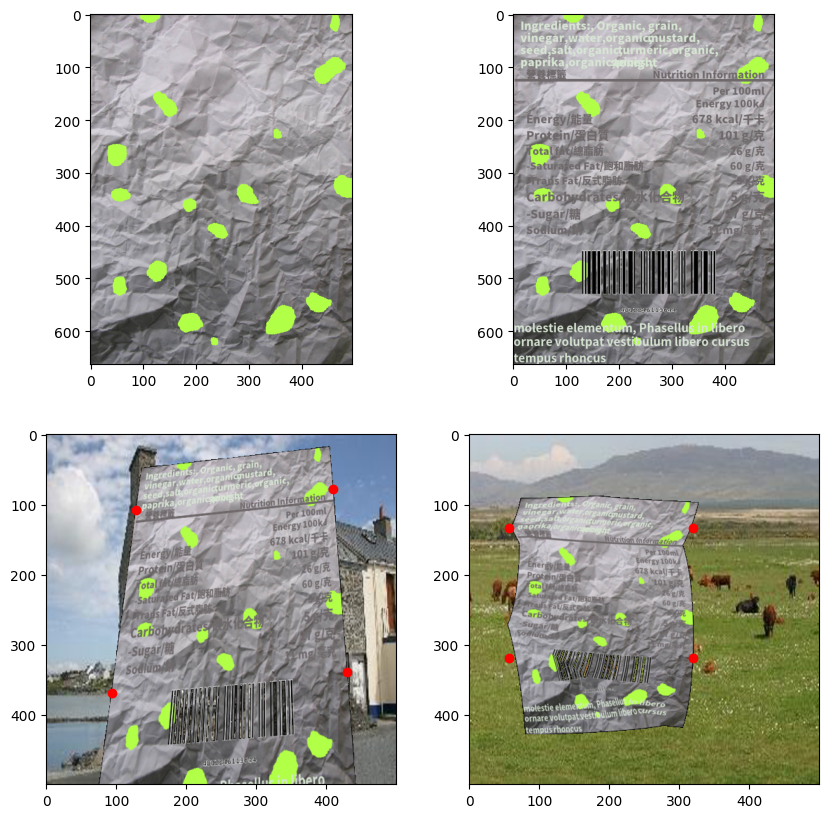

In [216]:
plt.subplots(2, 2, figsize=(10, 10))
product_bg = Image.open(
            random.choice(glob.glob("texture/" + '*.jpg')),
            mode='r'
            )
img = product_bg.resize((w, h))
img = draw_random_shape(img)
plt.subplot(2, 2, 1)
plt.imshow(img)
img, bboxes = draw_random_element(Image.fromarray(img))
plt.subplot(2, 2, 2)
plt.imshow(img)
# label = add_light_bubble(img)
label = np.array(img)
img1, bboxes1 = add_perspective_wrap(label, bboxes)
print(bboxes1)
img1, bboxes1 = paste_to_background(img1, bboxes1)
print(bboxes1)
plt.subplot(2, 2, 3)
plt.imshow(img1)
plt.scatter(bboxes1[0, ..., 0], bboxes1[0, ..., 1], c='r')
minx, miny = bboxes[0].min(axis=0)
maxx, maxy = bboxes[0].max(axis=0) 
print(minx, miny, maxx, maxy)
bbox = np.zeros(shape=label.shape[0:2])
bbox[miny:maxy, minx:maxx] = 255
img2, bbox = perturbed_mesh(label, bbox)
img2, bbox = perturbed_mesh(img2, bbox)
img2, bbox = perturbed_mesh(img2, bbox)
minx, maxx = np.where(bbox.any(axis=0))[0][[0, -1]]
miny, maxy = np.where(bbox.any(axis=1))[0][[0, -1]]
img2, bboxes2 = paste_to_background(img2, [[[minx, miny], [maxx, maxy]]])
print(bboxes2)
plt.subplot(2, 2, 4)
plt.imshow(img2)
minx, miny = bboxes2[0].min(axis=0)
maxx, maxy = bboxes2[0].max(axis=0) 
plt.scatter([minx, maxx, minx, maxx], [miny, miny, maxy, maxy], c='r')
plt.show()

y: 397
y: 0
y: 623
y: 316


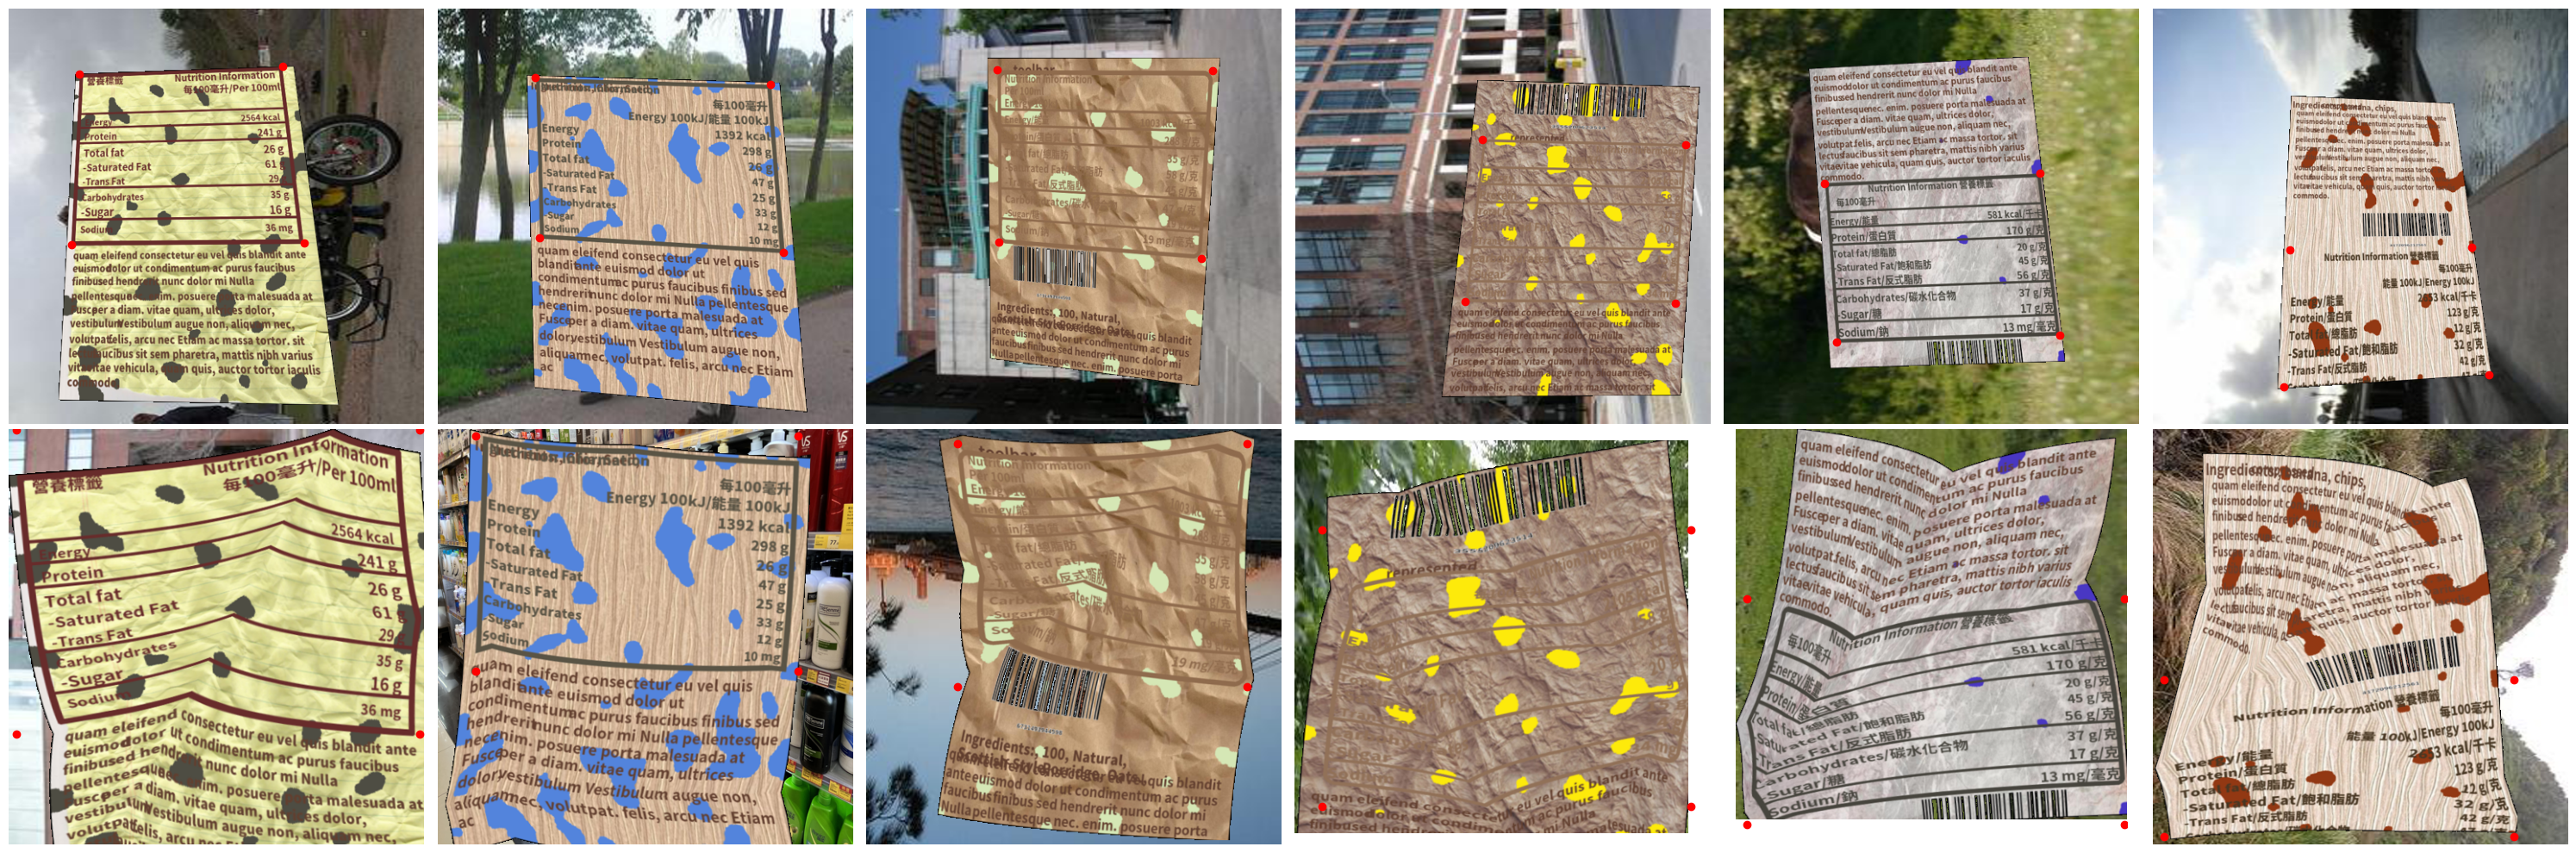

In [25]:
def plot():
        plt.subplots(2, 6, figsize=(30, 10))
        for i in range(6):
                product_bg = Image.open(
                        random.choice(glob.glob("texture/" + '*.jpg')),
                        mode='r'
                        )
                img = product_bg.resize((w, h))
                img = draw_random_shape(img)
                img, bboxes = draw_random_element(Image.fromarray(img))
                label = np.array(img)
                img1, bboxes1 = add_perspective_wrap(label, bboxes)
                img1, bboxes1 = paste_to_background(img1, bboxes1)
                plt.subplot(2, 6, i+1)
                plt.imshow(img1)
                plt.scatter(bboxes1[0, ..., 0], bboxes1[0, ..., 1], c='r')
                plt.axis('off')
                minx, miny = bboxes[0].min(axis=0)
                maxx, maxy = bboxes[0].max(axis=0) 
                bbox = np.zeros(shape=label.shape[0:2])
                bbox[miny:maxy, minx:maxx] = 255
                img2, bbox = perturbed_mesh(label, bbox)
                img2, bbox = perturbed_mesh(img2, bbox)
                img2, bbox = perturbed_mesh(img2, bbox)
                minx, maxx = np.where(bbox.any(axis=0))[0][[0, -1]]
                miny, maxy = np.where(bbox.any(axis=1))[0][[0, -1]]
                img2, bboxes2 = paste_to_background(img2, [[[minx, miny], [maxx, maxy]]])
                plt.subplot(2, 6, i+1+6)
                plt.imshow(img2)
                minx, miny = bboxes2[0].min(axis=0)
                maxx, maxy = bboxes2[0].max(axis=0) 
                plt.scatter([minx, maxx, minx, maxx], [miny, miny, maxy, maxy], c='r')
                plt.axis('off')
        plt.tight_layout()
        plt.show()
plot()

In [217]:
# plt.figure(figsize=(10,10))
# for i in range(4):
#     product_bg = Image.open(
#                 random.choice(glob.glob("texture/" + '*.jpg')),
#                 mode='r'
#                 )
#     img = product_bg.resize((w, h))
#     img = draw_random_shape(img)
#     img, bboxes = draw_random_element(Image.fromarray(img))
#     minx, miny = bboxes[0].min(axis=0)
#     maxx, maxy = bboxes[0].max(axis=0) 
#     bbox = np.zeros(shape=label.shape[0:2])
#     bbox[miny:maxy, minx:maxx] = 255
#     for j in range(3):
#         img, bbox = perturbed_mesh(np.array(img), bbox)
#     plt.subplot(2, 2, i + 1)
#     plt.imshow(img)
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig('synthetic2.png')
# plt.show()